In [21]:
from scipy.constants import c
from scipy.special import erf
import numpy as np
from numpy.lib import recfunctions as rec
from astropy.io          import fits
from astropy.coordinates import SkyCoord, Angle, search_around_sky
from astropy             import units as u
from astropy import cosmology
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
import pandas as pd
import math
from tqdm.notebook import tqdm
from scipy.optimize import minimize
import emcee
import iminuit
from iminuit import Minuit

In [11]:
def calc_sigma_v(theta, zcen, richness):
    """
    Calculate sigma_v (the width of the gaussian in our model)
    according to our model. Dependent on all parameters, as
    well as central galaxy info."""
    lnsigma_p, alpha, beta, z_p, lambda_p = theta
    return np.exp(lnsigma_p)*((1+zcen)/(1+z_p))**beta*(richness/lambda_p)**alpha

In [12]:
def calculate_vmax(richness):
    """Calculate the absolute velocity cutoff for interlopers in m/s.
    Follows equation (7) in redMaPPer IV.
    Parameters
    ----------
    richness : float
        Cluster richness, i.e. estimated number of galaxies belonging
        to the cluster.
    Returns
    -------
    vmax : float
        Maximum velocity value as set forth in equation (7) of redMaPPer IV.
        Units: m/s
    """
    vmax = 3e6 * (richness / 20.0) ** 0.45 /1000000 # 100km/s
    return vmax  # m/s

In [13]:
def background_gaussian(velocity, richness, total_sigma):
    """
    This function is used for evaluation of the line of sight
    gaussian. Sure, all Gaussians will have some fraction
    outside the vmax cut we made, and we'd have to normalize
    for that effect, but that amount is negligible for the
    orbiting and infalling Gaussians. But for the background
    Gaussian, a significant amount is cut off by the vmax cut,
    so I use an erf to scale and account for that."""
    vmax = 3e6 * (richness / 20.0) ** 0.45
    outside_cut = np.where(velocity > vmax)[0]
    assert len(outside_cut) == 0, "UH OH: VELOCITY DATA FED INTO MCMC IS OUTSIDE CUT"

    z = vmax*(0.5**0.5)/total_sigma
    area_inside = erf(z)
    #assert (area_inside != 0).all(), "Problem with vmax/sigma: " + str(vmax[np.where(z==0)]) + str(total_sigma[np.where(z==0)])
    normalization = 1/area_inside
    gaussian = np.exp(-0.5*((velocity/total_sigma)**2))/(np.sqrt(2*np.pi)*total_sigma)
    return_arr = normalization * gaussian

    if len(outside_cut) > 0:
        print("UH OH: VELOCITY DATA FED INTO MCMC IS OUTSIDE CUT")
        return_arr[outside_cut] = 0

    return return_arr

In [390]:
def lnlike2(parameters,v,r,rich,zcen,sigma_obs):
    a1, a2, b1, c1, c2, lnsp_orb, k, alpha_orb, beta_orb, lnsp_inf, alpha_inf, beta_inf, lnsp_los, alpha_los, beta_los, r_p, alpha_r, beta_r=parameters

    b0 = 1 + a1 + a2 #calculated from constraint equations
    c0 = -(c1 + c2) #calculated from constraint equations

    z_p = np.median(zcen)
    lambda_p = np.median(rich)

    r_edge = r_p*((1+zcen)/(1+z_p))**beta_r*(rich/lambda_p)**alpha_r

    f_good = b0 + b1*(r/r_edge-1)
    f_orb = np.zeros_like(r)

    lt_xt = np.where(r < r_edge)[0]
    f_good[lt_xt] = 1 + a1*r[lt_xt]/r_edge[lt_xt] + a2*((r[lt_xt]/r_edge[lt_xt])**2)
    f_orb[lt_xt] = c0 + c1*r[lt_xt]/r_edge[lt_xt] + c2*((r[lt_xt]/r_edge[lt_xt])**2)

    if 0.05 < alpha_orb < 1 and 0.05 < alpha_inf < 1 and 0.05 < alpha_los < 1 and -2 < alpha_r < 2 and -2 < beta_orb < 2 and -2 < beta_inf < 2 and -2 < beta_los < 2 and -2 < beta_r < 2 and 1 < lnsp_orb < 10 and 1 < lnsp_inf < 10 and lnsp_los < 50 and a1 < 0 and 0.2 < b0 < 1 and b1 < 0 and 0 < c0 <= 1 and c1 < 0 and (f_good > 0).all() and (f_orb >= 0).all() and 1 < r_p < 5 and k > 0:
        orb_sigmav = calc_sigma_v([lnsp_orb, alpha_orb, beta_orb, z_p, lambda_p], zcen, rich)/(1+k*r/r_edge)**0.5
        orb_sigmat = (orb_sigmav**2 + sigma_obs**2)**0.5
        orb_gaussian = np.exp(-0.5*((v/orb_sigmat)**2))/(np.sqrt(2*np.pi)*orb_sigmat)

        inf_sigmav = calc_sigma_v([lnsp_inf, alpha_inf, beta_inf, z_p, lambda_p], zcen, rich)
        inf_sigmat = (inf_sigmav**2 + sigma_obs**2)**0.5
        inf_gaussian = np.exp(-0.5*((v/inf_sigmat)**2))/(np.sqrt(2*np.pi)*inf_sigmat)

        los_sigmav = calc_sigma_v([lnsp_los, alpha_los, beta_los, z_p, lambda_p], zcen, rich)
        los_sigmat = (los_sigmav**2 + sigma_obs**2)**0.5
        los_gaussian = background_gaussian(v, rich, los_sigmat)
        
        return np.sum(np.log(f_good*(f_orb*orb_gaussian+(1-f_orb)*inf_gaussian)+(1-f_good)*los_gaussian))
    else:
        return np.inf

In [403]:
def nlnlike2(parameters,v,r,rich,zcen,sigma_obs):
    a1, a2, b1, c1, c2, lnsp_orb, k, alpha_orb, beta_orb, lnsp_inf, alpha_inf, beta_inf, lnsp_los, alpha_los, beta_los, r_p, alpha_r, beta_r=parameters

    b0 = 1 + a1 + a2 #calculated from constraint equations
    c0 = -(c1 + c2) #calculated from constraint equations

    z_p = np.median(zcen)
    lambda_p = np.median(rich)

    r_edge = r_p*((1+zcen)/(1+z_p))**beta_r*(rich/lambda_p)**alpha_r

    f_good = b0 + b1*(r/r_edge-1)
    f_orb = np.zeros_like(r)

    lt_xt = np.where(r < r_edge)[0]
    f_good[lt_xt] = 1 + a1*r[lt_xt]/r_edge[lt_xt] + a2*((r[lt_xt]/r_edge[lt_xt])**2)
    f_orb[lt_xt] = c0 + c1*r[lt_xt]/r_edge[lt_xt] + c2*((r[lt_xt]/r_edge[lt_xt])**2)

    if 0.05 < alpha_orb < 1 and 0.05 < alpha_inf < 1 and 0.05 < alpha_los < 1 and -2 < alpha_r < 2 and -2 < beta_orb < 2 and -2 < beta_inf < 2 and -2 < beta_los < 2 and -2 < beta_r < 2 and 1 < lnsp_orb < 10 and 1 < lnsp_inf < 10 and lnsp_los < 50 and a1 < 0 and 0.2 < b0 < 1 and b1 < 0 and 0 < c0 <= 1 and c1 < 0 and (f_good > 0).all() and (f_orb >= 0).all() and 1 < r_p < 5 and k > 0:
        orb_sigmav = calc_sigma_v([lnsp_orb, alpha_orb, beta_orb, z_p, lambda_p], zcen, rich)/(1+k*r/r_edge)**0.5
        orb_sigmat = (orb_sigmav**2 + sigma_obs**2)**0.5
        orb_gaussian = np.exp(-0.5*((v/orb_sigmat)**2))/(np.sqrt(2*np.pi)*orb_sigmat)

        inf_sigmav = calc_sigma_v([lnsp_inf, alpha_inf, beta_inf, z_p, lambda_p], zcen, rich)
        inf_sigmat = (inf_sigmav**2 + sigma_obs**2)**0.5
        inf_gaussian = np.exp(-0.5*((v/inf_sigmat)**2))/(np.sqrt(2*np.pi)*inf_sigmat)

        los_sigmav = calc_sigma_v([lnsp_los, alpha_los, beta_los, z_p, lambda_p], zcen, rich)
        los_sigmat = (los_sigmav**2 + sigma_obs**2)**0.5
        los_gaussian = background_gaussian(v, rich, los_sigmat)
        
        return -np.sum(np.log(f_good*(f_orb*orb_gaussian+(1-f_orb)*inf_gaussian)+(1-f_good)*los_gaussian))
    else:
        return -np.inf

In [248]:
def plot_fit(df,params,minr,maxr,num_resample,vfactor):
    z_p = np.median(df.zcen)
    lambda_p = np.median(df.rich)

    r_edge = r_p*((1+df.zcen)/(1+z_p))**beta_r*(df.rich/lambda_p)**alpha_r
    print("The mean value of R_edge is %.2f. (Should be roughly 1.8)" % np.mean(r_edge))
    print("The pivot richness is %.2f. (Should be roughly 32)" % lambda_p)
    print("The pivot redshift is %.2f. (Should be roughly 0.17)" % z_p)

    min_x = -6
    max_x = 6
    num_data_bin_edges = 30
    num_sim_bin_edges = 251

    a1, a2, b1, c1, c2, lnsp_orb, k, alpha_orb, beta_orb, lnsp_inf, alpha_inf, beta_inf, lnsp_los, alpha_los, beta_los, x_p, alpha_x, beta_x = params #unpacking parameters

    b0 = 1 + a1 + a2 #calculated from constraint equations
    c0 = -(c1 + c2) #calculated from constraint equations

    x_t = x_p*((1+df.zcen)/(1+z_p))**beta_x*(df.rich/lambda_p)**alpha_x

    #df2=df.loc[ (df.r/x_t>1.0) & (df.r/x_t <=1.5) ].copy()
    #df2=df2.reset_index()

    df2=df[ (df.r/x_t>minr) & (df.r/x_t <=maxr) ].copy()
    df2=df2.reset_index()

    rich=df2.rich
    zcen=df2.zcen
    x=df2.r
    v=df2.v
    sigma_obs = df2.sigma_obs
    x_t = x_p*((1+zcen)/(1+z_p))**beta_x*(rich/lambda_p)**alpha_x

    #assuming all are outside x_t
    f_good = b0 + b1*(x/x_t-1)
    f_orb = np.zeros_like(x)
    #find those where x is less than x_t
    lt_xt = np.where(x/x_t < 1)[0]

    #properly reassign those that are actually inside
    f_good[lt_xt] = 1 + a1*x[lt_xt]/x_t[lt_xt] + a2*((x[lt_xt]/x_t[lt_xt])**2)
    f_orb[lt_xt] = c0 + c1*x[lt_xt]/x_t[lt_xt] + c2*((x[lt_xt]/x_t[lt_xt])**2)

    #This sigma_v is just used to scale the plot, so I use orbiting to ensure that nothing is outside edges
    sigma_v = calc_sigma_v([lnsp_orb, alpha_orb, beta_orb, z_p, lambda_p], zcen, rich)/((1+k*x/x_t)**0.5)
    normalized_v = v/sigma_v

    data_x_vals = np.linspace(min_x, max_x, num_data_bin_edges)
    data_bin_centers = (data_x_vals[:-1] + data_x_vals[1:])/2.
    #err_bars, data_bin_centers = get_err(data, z_p, lambda_p, params, data_x_vals)
    sim_x_vals = np.linspace(min_x, max_x, num_sim_bin_edges)

    all_orb = np.ones([num_resample, num_sim_bin_edges-1])
    all_inf = np.ones([num_resample, num_sim_bin_edges-1])
    all_los = np.ones([num_resample, num_sim_bin_edges-1])

    data_x_vals = np.linspace(min_x, max_x, num_data_bin_edges)
    data_bin_centers = (data_x_vals[:-1] + data_x_vals[1:])/2.
    data_bin_width = data_bin_centers[1] - data_bin_centers[0]

    print("Maximum normalized velocity %.2f. (Should be roughly 8)" % np.max(vfactor*normalized_v))
    counts, bin_edges = np.histogram(vfactor*normalized_v, data_x_vals)
    normalized_counts = counts / float(len(v)) / data_bin_width

    for i in tqdm(range(num_resample)):
        fraction = np.random.rand(len(x))
        orb = np.where(fraction < f_good * f_orb)[0]
        inf = np.where((f_good * f_orb <= fraction) & (fraction < f_good))[0]
        los = np.where(fraction >= f_good)[0]

        assert len(los) + len(orb) + len(inf) == len(x), "Uh-oh: check np.where assignment at beginning of sample"
        orb_sigmav = calc_sigma_v([lnsp_orb, alpha_orb, beta_orb, z_p, lambda_p], zcen[orb], rich[orb])/((1+k*x[orb]/x_t[orb])**0.5)
        orb_sigmat = (orb_sigmav**2 + sigma_obs[orb]**2)**0.5
        orb_v = np.random.normal(0, orb_sigmat)
        inf_sigmav = calc_sigma_v([lnsp_inf, alpha_inf, beta_inf, z_p, lambda_p], zcen[inf], rich[inf])
        inf_sigmat = (inf_sigmav**2 + sigma_obs[inf]**2)**0.5
        inf_v = np.random.normal(0, inf_sigmat)
        los_sigmav = calc_sigma_v([lnsp_los, alpha_los, beta_los, z_p, lambda_p], zcen[los], rich[los])
        los_sigmat = (los_sigmav**2 + sigma_obs[los]**2)**0.5
        los_v = np.random.normal(0, los_sigmat)

        orb_v_by_sig_v = orb_v / sigma_v[orb]
        inf_v_by_sig_v = inf_v / sigma_v[inf]
        los_v_by_sig_v = los_v / sigma_v[los]

        all_orb[i], bin_edges = np.histogram(orb_v_by_sig_v, sim_x_vals)
        all_inf[i], bin_edges = np.histogram(inf_v_by_sig_v, sim_x_vals)
        all_los[i], bin_edges = np.histogram(los_v_by_sig_v, sim_x_vals)

    sim_bin_centers = (sim_x_vals[:-1] + sim_x_vals[1:])/2.
    sim_bin_width = sim_bin_centers[1] - sim_bin_centers[0]

    orb_averaged = np.mean(all_orb, axis=0)
    orb_normalized = orb_averaged / float(len(x)) / sim_bin_width

    inf_averaged = np.mean(all_inf, axis=0)
    inf_normalized = inf_averaged / float(len(x)) / sim_bin_width

    los_averaged = np.mean(all_los, axis=0)
    los_normalized = los_averaged / float(len(x)) / sim_bin_width

    fig, axes = plt.subplots(figsize=(10,7))
    orb_lines = axes.plot(sim_bin_centers, orb_normalized, linewidth=1, ls="dashdot")
    inf_lines = axes.plot(sim_bin_centers, inf_normalized, linewidth=1, ls="dotted")
    los_lines = axes.plot(sim_bin_centers, los_normalized, linewidth=1, ls="dashed")
    sum_lines = axes.plot(sim_bin_centers, orb_normalized + inf_normalized + los_normalized, linewidth=1)
    axes.errorbar(data_bin_centers,normalized_counts,yerr=np.sqrt(counts)/float(len(v)) / data_bin_width,fmt="ko",markersize=1.5,elinewidth=0.8,capsize=1.8)
    axes.set_ylim(0,0.5)
    axes.set_xlabel('$v$ / $\sigma_{v,orb}$')
    axes.set_ylabel('P($v$ / $\sigma_{v,orb})$')

In [16]:
#Parameters from 'Clusters have Edges'
a1=-0.512
a2=-0.032
b1=-0.010
c1=-0.061
c2=-0.693

sp_orb=7.77
lnsp_orb=np.log(sp_orb)
alpha_orb=0.43
beta_orb=0.353

sp_inf=4.48
lnsp_inf=np.log(sp_inf)
alpha_inf=0.363
beta_inf=0.113

sp_los=38.73
lnsp_los=np.log(sp_los)
alpha_los=0.503
beta_los=-0.328

alpha_r=0.305
beta_r=-0.385
r_p=1.79
k=0.883

origin=[a1, a2, b1, c1, c2, lnsp_orb, k, alpha_orb, beta_orb, lnsp_inf, alpha_inf, beta_inf, lnsp_los, alpha_los, beta_los, r_p, alpha_r, beta_r]
origin=np.array(origin)

In [26]:
#Parameters that Paxton's mcmc is initialized with
origin2 = [-0.45, -0.08, -0.1, -0.5, -0.2, 8.65, 0.9, 0.5, -0.25, 8.1, 0.38, -0.7, 10.3, 0.5, -0.4, 2, 0, -0.5]


In [17]:
#Parameters from 'Clusters have Edges'
da1=0.3
da2=0.053
db1=0.1
dc1=0.180
dc2=0.4

dsp_orb=0.21
dlnsp_orb=-np.log(dsp_orb)
dalpha_orb=0.019
dbeta_orb=0.195

dsp_inf=0.06
dlnsp_inf=-np.log(dsp_inf)
dalpha_inf=0.363
dbeta_inf=0.180

dsp_los=1.16
dlnsp_los=np.log(dsp_los)
dalpha_los=0.066
dbeta_los=0.48

dalpha_r=0.034
dbeta_r=0.289
dr_p=0.12
dk=0.238

delta=[da1, da2, db1, dc1, dc2, dlnsp_orb, -dk, dalpha_orb, dbeta_orb, dlnsp_inf, dalpha_inf, dbeta_inf, dlnsp_los, dalpha_los, dbeta_los, dr_p, dalpha_r, dbeta_r]
delta=np.array(delta)

In [202]:
fname = "last_catalog.npy"
dt = np.load(fname)
pax=pd.DataFrame.from_records(dt.tolist(), columns=dt.dtype.names)
rich=pax.LAMBDA_CHISQ
zcen=pax.BCG_SPEC_Z
r=pax.R
x=pax.R/pax.R_LAMBDA
v=pax.Velocity / 100000
ra=pax.MEM_RA
dec=pax.MEM_DEC
sigma_obs = c*((pax.ZMEM_ERR**2 + pax.ZCEN_ERR**2)**(0.5)) / 100000
pax=pd.DataFrame({'rich':rich,'zcen':zcen,'x':x,'r':r,'v':v,'ra':ra,'dec':dec,'sigma_obs':sigma_obs});
df=pax

In [227]:
lik_model = minimize(nlnlike2, origin, args=(v,r,rich,zcen,sigma_obs), method='Nelder-Mead',options={'maxiter': 1e4})

In [108]:
min=np.array([-1,-1,-1,-1,-1,1,0,0.05,-2,1,0.05,-2,1,0.05,-2,1,-2,-2])
max=np.array([0,1,0,0,0,10,1,1,2,10,1,2,50,1,2,5,2,2])

bnds=[(x,y) for x, y in zip(min, max)]

minuit_model = iminuit.minimize(nlnlike2, origin, args=(v,r,rich,zcen,sigma_obs),bounds=bnds)

In [228]:
lik_model.x

array([-7.09544859e-01,  1.92745015e-02, -6.54307506e-02, -1.02942990e-09,
       -9.33395200e-01,  2.00419922e+00,  1.43984089e+00,  4.30109460e-01,
       -1.85460494e-03,  1.24353902e+00,  3.55737109e-01,  1.26346394e-01,
        2.91630909e+00,  4.56804404e-01, -3.73106064e-01,  1.75315441e+00,
        3.50999931e-01,  8.39338627e-02])

In [260]:
minuit_model.x

array([-8.02581177e-01,  1.27792879e-01, -9.89207610e-02, -3.21414942e-06,
       -9.11594772e-01,  1.96199655e+00,  1.00000000e+00,  4.24254925e-01,
        3.78931660e-01,  1.24057430e+00,  3.63963798e-01, -1.50078735e-01,
        2.91363794e+00,  4.54650495e-01, -6.40736337e-02,  1.82678256e+00,
        3.39660583e-01, -6.68730735e-01])

In [229]:
nlnlike2(origin2,v,r,rich,zcen,sigma_obs)

833468.4847953533

In [230]:
nlnlike2(origin,v,r,rich,zcen,sigma_obs)

356041.8714201489

In [231]:
nlnlike2(lik_model.x,v,r,rich,zcen,sigma_obs)

344806.5698893919

In [232]:
nlnlike2(minuit_model.x,v,r,rich,zcen,sigma_obs)

344775.88250114047

The simplex method is giving a slightly better goodness-of-fit because the simplex method does not allow bounds, and the value of 'k' is above one. If you look at the minuit model, k is as close to 1 as it can be, leading me to suspect it 'wants' to be higher than 1. Why is k bounded in this way?

Note both methods suggest R_p=1.8, confirming the paper's results. However, they disagree on other parameters.

A quick check: is minuit sensitive to starting guess? Answer:yes

In [105]:
origin2 = [-0.45, -0.08, -0.1, -0.5, -0.2, 8.65, 0.9, 0.5, -0.25, 8.1, 0.38, -0.7, 10.3, 0.5, -0.4, 2, 0, -0.5]
min=np.array([-1,-1,-1,-1,-1,1,0,0.05,-2,1,0.05,-2,1,0.05,-2,1,-2,-2])
max=np.array([0,1,0,0,0,10,1,1,2,10,1,2,50,1,2,5,2,2])

bnds=[(x,y) for x, y in zip(min, max)]

minuit_model2 = iminuit.minimize(nlnlike2, origin2, args=(v,r,rich,zcen,sigma_obs),bounds=bnds)

In [115]:
minuit_model2.x

array([-1.79828844e-01, -8.26085769e-02, -2.90790954e-08, -4.09180964e-01,
       -5.20557435e-01,  1.90199490e+00,  9.99999480e-01,  4.18562225e-01,
        3.24656399e-01,  2.91328614e+00,  4.53416515e-01, -6.00183458e-02,
        1.20791265e+00,  3.41783687e-01,  8.74234922e-02,  1.91037307e+00,
        3.83699144e-01, -9.37520552e-01])

In [116]:
nlnlike2(minuit_model2.x,v,r,rich,zcen,sigma_obs)

344846.22656554607

Is simplex sensitive to initial guess? Yes, and it doesn't even get r_p right.

In [98]:
lik_model2 = minimize(nlnlike2, origin2, args=(v,r,rich,zcen,sigma_obs), method='Nelder-Mead',options={'maxiter': 1e4})

In [99]:
lik_model2.x

array([-4.46372976e-01, -7.51438079e-02, -1.10066896e-01, -3.28851723e-01,
       -1.87956448e-01,  9.91993217e+00,  9.65494354e-01,  5.16002261e-02,
       -3.71985844e-01,  1.56514103e+00,  9.84859678e-01, -1.00151707e+00,
        2.90387097e+00,  3.01079732e-01, -3.00089956e-01,  1.06830514e+00,
        2.31712808e-03, -6.74297611e-01])

In [100]:
nlnlike2(lik_model2.x,v,r,rich,zcen,sigma_obs)

353629.31256090157

Is mcmc sensitive to initial guess? Yes, it is the most sensitive/time consuming. First, run mcmc starting at the parameters from Paxton's code

In [75]:
#Parameters that Paxton's mcmc is initialized with

origin2 = [-0.45, -0.08, -0.1, -0.5, -0.2, 8.65, 0.9, 0.5, -0.25, 8.1, 0.38, -0.7, 10.3, 0.5, -0.4, 2, 0, -0.5]
delta2 = [0.02, 0.003, 0.02, 0.04, 0.04, 0.06, 0.05, 0.015, 0.06, 0.06, 0.01, 0.04, 0.08, 0.03, 0.08, 0.1, 0.05, 0.08]
ndim, nwalkers = 18,40
pos = [origin2 + delta2*np.random.randn(ndim) for i in range(nwalkers)]
#Now I set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike2, args=(v,r,rich,zcen,sigma_obs))

In [382]:
sampler.run_mcmc(pos, 100); #run a 1000 length chain starting at pos

emcee: Exception while calling your likelihood function:
  params: [-0.7919827   0.12407904 -0.10705181 -0.14595684 -0.90418487  2.12362311
  1.00119879  0.43461603  0.77816799  1.32295567  0.32792152 -0.02341336
  2.91135664  0.45861348  0.01086295  1.88753563  0.32169682 -1.08175365]
  args: (0        32.017882
1         2.896913
2       -72.147290
3        12.234623
4         5.398347
           ...    
86544   -27.289372
86545    18.177100
86546    20.168940
86547    14.085570
86548     4.743743
Name: Velocity, Length: 86549, dtype: float64, 0        0.061084
1        0.567881
2        3.929191
3        1.381477
4        3.808188
           ...   
86544    3.500576
86545    1.853715
86546    2.611667
86547    3.085646
86548    0.683896
Name: R, Length: 86549, dtype: float64, 0        190.996490
1        190.996490
2        190.996490
3        190.996490
4        190.996490
            ...    
86544     20.217054
86545     20.217054
86546     20.217054
86547     30.834517
86548     

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-14-1afdecbdc21f>", line 29, in lnlike2
    los_gaussian = background_gaussian(v, rich, los_sigmat)
  File "<ipython-input-13-16dd382fad4f>", line 10, in background_gaussian
    vmax = 3e6 * (richness / 20.0) ** 0.45
  File "/usr/local/lib64/python3.7/site-packages/pandas/core/ops/__init__.py", line 1048, in wrapper
    result = na_op(lvalues, rvalues)
  File "/usr/local/lib64/python3.7/site-packages/pandas/core/ops/__init__.py", line 968, in na_op
    result = expressions.evaluate(op, str_rep, x, y, **eval_kwargs)
  File "/usr/local/lib64/python3.7/site-packages/pandas/core/computation/expressions.py", line 221, in evaluate
    return _evaluate(op, op_str, a, b, **eval_kwargs)
  File "/usr/local/lib64/python3.7/site-packages/pandas/core/computation/expressions.py", line 70, in _evaluate_standar

KeyboardInterrupt: 

In [77]:
#Getting the values that maximize likelihood
flat_chain = np.concatenate(sampler.chain)
flat_lnprobs = np.concatenate(sampler.lnprobability)
max_prob_idx = np.argmax(flat_lnprobs)
max_prob = flat_lnprobs[max_prob_idx]
#p, lnsigma_p, alpha, beta = flat_chain[max_prob_idx]
mcmc_initial=flat_chain[max_prob_idx]

In [78]:
mcmc_initial

array([-3.88631234e-01,  8.47319996e-03, -1.70691867e-01, -8.63205443e-03,
       -1.68953485e-01,  9.92517872e+00,  8.10040571e-01,  3.01929981e-01,
       -1.09904082e+00,  6.88483606e+00,  1.81561206e-01,  7.36376417e-02,
        1.11189909e+01,  7.10649578e-01,  1.16897195e+00,  2.61805004e+00,
        1.20599158e-01, -1.20344477e+00])

In [92]:
nlnlike2(mcmc_initial,v,r,rich,zcen,sigma_obs)

712898.8129275201

Now, run mcmc starting at the parameters from 'Clusters have edges'

In [387]:
#Now I begin to sample from our parameter space of good likelihood and run the MCMC.
ndim, nwalkers = 18,40
pos = [origin + delta*np.random.randn(ndim) for i in range(nwalkers)]
#Now I set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike2, args=(v,r,rich,zcen,sigma_obs))

In [83]:
sampler.run_mcmc(pos, 100); #run a 1000 length chain starting at pos

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [84]:
#Getting the values that maximize likelihood
flat_chain = np.concatenate(sampler.chain)
flat_lnprobs = np.concatenate(sampler.lnprobability)
max_prob_idx = np.argmax(flat_lnprobs)
max_prob = flat_lnprobs[max_prob_idx]
#p, lnsigma_p, alpha, beta = flat_chain[max_prob_idx]
mcmc_paper=flat_chain[max_prob_idx]

In [85]:
mcmc_paper

array([-1.83000752e-03, -4.04748216e-02, -5.49478690e-03, -2.60509491e-01,
       -5.78320291e-01,  1.59302315e+00,  2.40272178e-01,  4.23148469e-01,
        8.17615950e-01,  2.85900533e+00,  5.99106191e-02,  5.60882156e-01,
        3.88002573e+00,  5.14948287e-01, -1.19294084e+00,  1.68803361e+00,
        3.12312979e-01, -6.95708609e-01])

In [91]:
nlnlike2(mcmc_paper,v,r,rich,zcen,sigma_obs)

351921.51041504863

Last, run mcmc starting at parameters from minuit

In [409]:
#Now I begin to sample from our parameter space of good likelihood and run the MCMC.
ndim, nwalkers = 18,40
pos = [minuit_model.x + delta_minuit*np.random.randn(ndim) for i in range(nwalkers)]
#Now I set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike2, args=(v,r,rich,zcen,sigma_obs))

In [410]:
sampler.run_mcmc(pos, 1000); #run a 1000 length chain starting at pos

In [411]:
#Getting the values that maximize likelihood
flat_chain = np.concatenate(sampler.chain)
flat_lnprobs = np.concatenate(sampler.lnprobability)
max_prob_idx = np.argmax(flat_lnprobs)
max_prob = flat_lnprobs[max_prob_idx]
#p, lnsigma_p, alpha, beta = flat_chain[max_prob_idx]
mcmc_minuit=flat_chain[max_prob_idx]

In [425]:
nlnlike4(mcmc_minuit,v,r,rich,zcen,sigma_obs)

-351983.00513626955

In [416]:
mcmc_minuit

array([-0.81191332,  0.12276539, -0.09473739,  0.03110172, -0.90222122,
        1.        ,  1.00068911,  0.4100951 ,  0.43334313,  1.24695698,
        0.3736719 , -0.13504192,  2.96245612,  0.45536402, -0.11699797,
        1.75803228,  0.32679538, -1.22940735])

The mean value of R_edge is 1.81. (Should be roughly 1.8)
The pivot richness is 32.19. (Should be roughly 32)
The pivot redshift is 0.17. (Should be roughly 0.17)
Maximum normalized velocity 16.55. (Should be roughly 6)


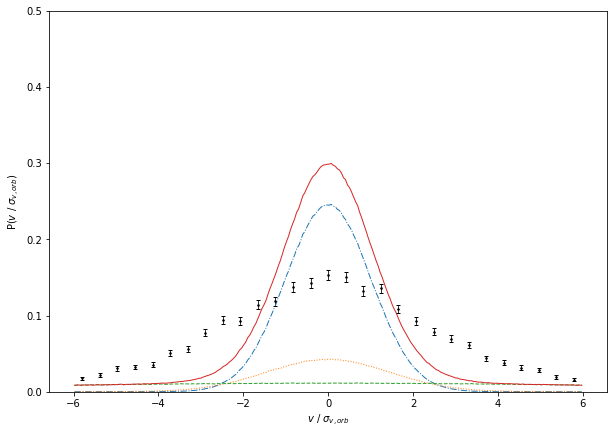

In [430]:
plot_fit(df,mcmc_minuit,0.2,0.4,1000,1)

The mean value of R_edge is 1.89. (Should be roughly 1.8)
The pivot richness is 32.19. (Should be roughly 32)
The pivot redshift is 0.17. (Should be roughly 0.17)
Maximum normalized velocity 5.54. (Should be roughly 6)


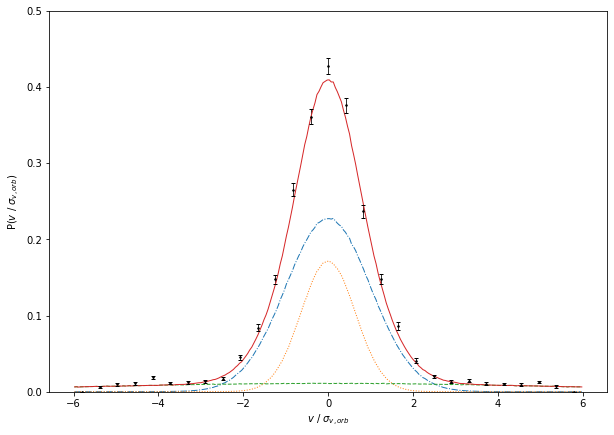

In [379]:
plot_fit(df,origin,0.2,0.4,1000,1)

The mean value of R_edge is 1.89. (Should be roughly 1.8)
The pivot richness is 32.19. (Should be roughly 32)
The pivot redshift is 0.17. (Should be roughly 0.17)
Maximum normalized velocity 6.25. (Should be roughly 6)


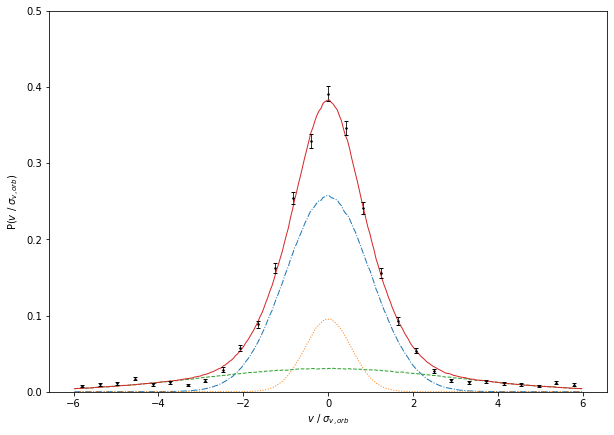

In [397]:
plot_fit(df,minuit_model.x,0.2,0.4,1000,1)

The mean value of R_edge is 1.89. (Should be roughly 1.8)
The pivot richness is 32.19. (Should be roughly 32)
The pivot redshift is 0.17. (Should be roughly 0.17)
Maximum normalized velocity 6.26. (Should be roughly 6)


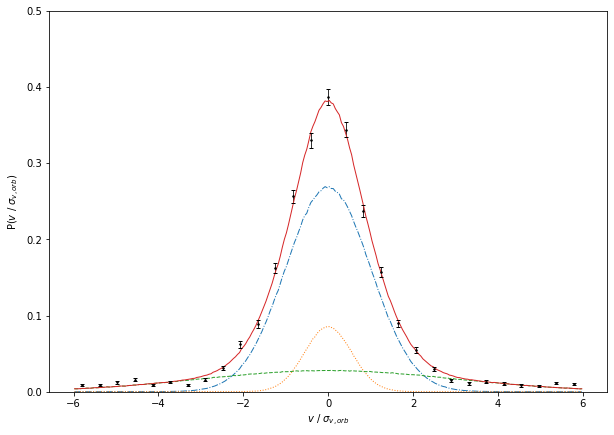

In [398]:
plot_fit(df,lik_model.x,0.2,0.4,1000,1)

Output and compare parameters. Are they significantly different?

In [424]:
def nlnlike3(parameters):
    
    global v,r,rich,zcen,sigma_obs
    a1, a2, b1, c1, c2, lnsp_orb, k, alpha_orb, beta_orb, lnsp_inf, alpha_inf, beta_inf, lnsp_los, alpha_los, beta_los, r_p, alpha_r, beta_r=parameters

    b0 = 1 + a1 + a2 #calculated from constraint equations
    c0 = -(c1 + c2) #calculated from constraint equations

    z_p = np.median(zcen)
    lambda_p = np.median(rich)

    r_edge = r_p*((1+zcen)/(1+z_p))**beta_r*(rich/lambda_p)**alpha_r

    f_good = b0 + b1*(r/r_edge-1)
    f_orb = np.zeros_like(r)

    lt_xt = np.where(r < r_edge)[0]
    f_good[lt_xt] = 1 + a1*r[lt_xt]/r_edge[lt_xt] + a2*((r[lt_xt]/r_edge[lt_xt])**2)
    f_orb[lt_xt] = c0 + c1*r[lt_xt]/r_edge[lt_xt] + c2*((r[lt_xt]/r_edge[lt_xt])**2)

    orb_sigmav = calc_sigma_v([lnsp_orb, alpha_orb, beta_orb, z_p, lambda_p], zcen, rich)/(1+k*r/r_edge)**0.5
    orb_sigmat = (orb_sigmav**2 + sigma_obs**2)**0.5
    orb_gaussian = np.exp(-0.5*((v/orb_sigmat)**2))/(np.sqrt(2*np.pi)*orb_sigmat)

    inf_sigmav = calc_sigma_v([lnsp_inf, alpha_inf, beta_inf, z_p, lambda_p], zcen, rich)
    inf_sigmat = (inf_sigmav**2 + sigma_obs**2)**0.5
    inf_gaussian = np.exp(-0.5*((v/inf_sigmat)**2))/(np.sqrt(2*np.pi)*inf_sigmat)

    los_sigmav = calc_sigma_v([lnsp_los, alpha_los, beta_los, z_p, lambda_p], zcen, rich)
    los_sigmat = (los_sigmav**2 + sigma_obs**2)**0.5
    los_gaussian = background_gaussian(v, rich, los_sigmat)

    if 0.05 < alpha_orb < 1 and 0.05 < alpha_inf < 1 and 0.05 < alpha_los < 1 and -2 < alpha_r < 2 and -2 < beta_orb < 2 and -2 < beta_inf < 2 and -2 < beta_los < 2 and -2 < beta_r < 2 and 1 < lnsp_orb < 10 and 1 < lnsp_inf < 10 and lnsp_los < 50 and a1 < 0 and 0.2 < b0 < 1 and b1 < 0 and 0 < c0 <= 1 and c1 < 0 and (f_good > 0).all() and (f_orb >= 0).all() and 1 < r_p < 5 and k > 0:
        lp=0
    else:
        lp=-1e100
        
    return -np.sum(np.log(f_good*(f_orb*orb_gaussian+(1-f_orb)*inf_gaussian)+(1-f_good)*los_gaussian))-lp

In [346]:
fname = "last_catalog.npy"
dt = np.load(fname)
pax=pd.DataFrame.from_records(dt.tolist(), columns=dt.dtype.names)
rich=pax.LAMBDA_CHISQ
zcen=pax.BCG_SPEC_Z
r=pax.R
x=pax.R/pax.R_LAMBDA
v=pax.Velocity / 100000
ra=pax.MEM_RA
dec=pax.MEM_DEC
sigma_obs = c*((pax.ZMEM_ERR**2 + pax.ZCEN_ERR**2)**(0.5)) / 100000
pax=pd.DataFrame({'rich':rich,'zcen':zcen,'x':x,'r':r,'v':v,'ra':ra,'dec':dec,'sigma_obs':sigma_obs});
df=pax

origin2=(a1, a2, b1, c1, c2, lnsp_orb, k, alpha_orb, beta_orb, lnsp_inf, alpha_inf, beta_inf, lnsp_los, alpha_los, beta_los, r_p, alpha_r, beta_r)
min=np.array([-1,-1,-1,-1,-1,1,0,0.05,-2,1,0.05,-2,1,0.05,-2,1,-2,-2])
max=np.array([0,1,0,0,0,10,1,1,2,10,1,2,50,1,2,5,2,2])

bnds=[(x,y) for x, y in zip(min, max)]

m = Minuit.from_array_func(nlnlike3, origin2,limit=bnds,errordef=0.5,pedantic=False)

In [347]:
m.migrad()

------------------------------------------------------------------
| FCN = 3.448E+05               |    Ncalls=2303 (2303 total)    |
| EDM = 0.00629 (Goal: 0.0001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   -0.80   |    0.04   |            |            |   -1    |    0    |       |
| 1 | x1   |   0.13    |   0.04    |            |            |   -1    |    1    |       |
| 2 | x2   |  -0.099   |   0.008   |            |            |   -1    |    0    |       |
| 3 | x3   | -0.000E-1 |  0.834E-1 |            |            |   -1    |    0    |       |
| 4 | x4   |  -0.911   |   0.029   |            |            |   -1    |    0    |       |
| 5 | x5   |   1.962   |   0.014   |            |            |    1    |   10    |       |
| 6 | x6   |   1.000   |   0.021   |            |            |    0    |    1    |       |
| 7 | x7   |   0.424   |   0.017   |            |            |  0.05   |    1    |       |
| 8 | x8   |   0.38    |   0.16    |            |            |   -2    |    2    |       |
| 9 | x9   |   1.241   |   0.014   |            |            |    1    |   10    |       |
| 10| x10  |   0.364   |   0.024   |            |            |  0.05   |    1    |       |
| 11| x11  |   -0.15   |    0.22   |            |            |   -2    |    2    |       |
| 12| x12  |   2.914   |   0.004   |            |            |    1    |   50    |       |
| 13| x13  |   0.455   |   0.009   |            |            |  0.05   |    1    |       |
| 14| x14  |   -0.06   |    0.08   |            |            |   -2    |    2    |       |
| 15| x15  |   1.83    |   0.05    |            |            |    1    |    5    |       |
| 16| x16  |   0.34    |   0.04    |            |            |   -2    |    2    |       |
| 17| x17  |   -0.67   |    0.28   |            |            |   -2    |    2    |       |
------------------------------------------------------------------------------------------

In [348]:
a1, a2, b1, c1, c2, lnsp_orb, k, alpha_orb, beta_orb, lnsp_inf, alpha_inf, beta_inf, lnsp_los, alpha_los, beta_los, r_p, alpha_r, beta_r=origin

In [349]:
da1, da2, db1, dc1, dc2, dlnsp_orb, dk, dalpha_orb, dbeta_orb, dlnsp_inf, dalpha_inf, dbeta_inf, dlnsp_los, dalpha_los, dbeta_los, dr_p, dalpha_r, dbeta_r=delta

In [350]:
print("Paper model parameters")
print("a1 = %.3f" % a1,u"\u00B1", "%.3f" % da1)
print("a2 = %.3f" % a2,u"\u00B1", "%.3f" % da2)
print("b1 = %.3f" % b1,u"\u00B1", "%.3f" % db1)
print("c1 = %.3f" % c1,u"\u00B1", "%.3f" % dc1)
print("c2 = %.3f" % c2,u"\u00B1", "%.3f" % dc2)
print("sp_orb = %.3f" % np.exp(lnsp_orb),u"\u00B1", "%.3f" % dlnsp_orb)
print("sp_inf = %.3f" % np.exp(lnsp_inf),u"\u00B1", "%.3f" % dlnsp_inf,)
print("sp_los = %.3f" % np.exp(lnsp_los),u"\u00B1", "%.3f" % dlnsp_los)
print("alpha_orb = %.3f" % alpha_orb,u"\u00B1", "%.3f" % dalpha_orb)
print("alpha_inf = %.3f" % alpha_inf,u"\u00B1", "%.3f" % dalpha_inf)
print("alpha_los = %.3f" % alpha_los,u"\u00B1", "%.3f" % dalpha_los)
print("beta_orb = %.3f" % beta_orb,u"\u00B1", "%.3f" % dbeta_orb)
print("beta_inf = %.3f" % beta_inf,u"\u00B1", "%.3f" % dbeta_orb)
print("beta_los = %.3f" % beta_los,u"\u00B1", "%.3f" % dbeta_los)
print("alpha_r = %.3f" % alpha_r,u"\u00B1", "%.3f" % dalpha_r)
print("beta_r = %.3f" % beta_r,u"\u00B1", "%.3f" % dbeta_r)
print("r_p = %.3f" % r_p,u"\u00B1", "%.3f" % dr_p)

Paper model parameters
a1 = -0.512 ± 0.300
a2 = -0.032 ± 0.053
b1 = -0.010 ± 0.100
c1 = -0.061 ± 0.180
c2 = -0.693 ± 0.400
sp_orb = 7.770 ± 1.561
sp_inf = 4.480 ± 2.813
sp_los = 38.730 ± 0.148
alpha_orb = 0.430 ± 0.019
alpha_inf = 0.363 ± 0.363
alpha_los = 0.503 ± 0.066
beta_orb = 0.353 ± 0.195
beta_inf = 0.113 ± 0.195
beta_los = -0.328 ± 0.480
alpha_r = 0.305 ± 0.034
beta_r = -0.385 ± 0.289
r_p = 1.790 ± 0.120


In [351]:
a1, a2, b1, c1, c2, lnsp_orb, k, alpha_orb, beta_orb, lnsp_inf, alpha_inf, beta_inf, lnsp_los, alpha_los, beta_los, r_p, alpha_r, beta_r=m.values[0],m.values[1],m.values[2],m.values[3],m.values[4],m.values[5],m.values[6],m.values[7],m.values[8],m.values[9],m.values[10],m.values[11],m.values[12],m.values[13],m.values[14],m.values[15],m.values[16],m.values[17]

In [352]:
da1, da2, db1, dc1, dc2, dlnsp_orb, dk, dalpha_orb, dbeta_orb, dlnsp_inf, dalpha_inf, dbeta_inf, dlnsp_los, dalpha_los, dbeta_los, dr_p, dalpha_r, dbeta_r=m.errors[0],m.errors[1],m.errors[2],m.errors[3],m.errors[4],m.errors[5],m.errors[6],m.errors[7],m.errors[8],m.errors[9],m.errors[10],m.errors[11],m.errors[12],m.errors[13],m.errors[14],m.errors[15],m.errors[16],m.errors[17]

In [408]:
delta_minuit=[da1, da2, db1, -dc1, dc2, dlnsp_orb*np.exp(lnsp_orb), -dk, dalpha_orb, dbeta_orb, dlnsp_inf*np.exp(lnsp_inf), dalpha_inf, dbeta_inf, dlnsp_los*np.exp(lnsp_los), dalpha_los, dbeta_los, dr_p, dalpha_r, dbeta_r]
delta_minuit=np.array(delta_minuit)

In [354]:
print("Minuit model parameters")
print("a1 = %.3f" % a1,u"\u00B1", "%.3f" % da1)
print("a2 = %.3f" % a2,u"\u00B1", "%.3f" % da2)
print("b1 = %.3f" % b1,u"\u00B1", "%.3f" % db1)
print("c1 = %.3f" % c1,u"\u00B1", "%.3f" % dc1)
print("c2 = %.3f" % c2,u"\u00B1", "%.3f" % dc2)
print("sp_orb = %.3f" % np.exp(lnsp_orb),u"\u00B1", "%.3f" % np.multiply(dlnsp_orb,np.exp(lnsp_orb)))
print("sp_inf = %.3f" % np.exp(lnsp_inf),u"\u00B1", "%.3f" % np.multiply(dlnsp_inf,np.exp(lnsp_inf)))
print("sp_los = %.3f" % np.exp(lnsp_los),u"\u00B1", "%.3f" % np.multiply(dlnsp_los,np.exp(lnsp_los)))
print("alpha_orb = %.3f" % alpha_orb,u"\u00B1", "%.3f" % dalpha_orb)
print("alpha_inf = %.3f" % alpha_inf,u"\u00B1", "%.3f" % dalpha_inf)
print("alpha_los = %.3f" % alpha_los,u"\u00B1", "%.3f" % dalpha_los)
print("beta_orb = %.3f" % beta_orb,u"\u00B1", "%.3f" % dbeta_orb)
print("beta_inf = %.3f" % beta_inf,u"\u00B1", "%.3f" % dbeta_orb)
print("beta_los = %.3f" % beta_los,u"\u00B1", "%.3f" % dbeta_los)
print("alpha_r = %.3f" % alpha_r,u"\u00B1", "%.3f" % dalpha_r)
print("beta_r = %.3f" % beta_r,u"\u00B1", "%.3f" % dbeta_r)
print("r_p = %.3f" % r_p,u"\u00B1", "%.3f" % dr_p)

Minuit model parameters
a1 = -0.802 ± 0.042
a2 = 0.128 ± 0.039
b1 = -0.099 ± 0.008
c1 = -0.000 ± 0.083
c2 = -0.911 ± 0.029
sp_orb = 7.114 ± 0.102
sp_inf = 3.458 ± 0.048
sp_los = 18.424 ± 0.072
alpha_orb = 0.424 ± 0.017
alpha_inf = 0.364 ± 0.024
alpha_los = 0.455 ± 0.009
beta_orb = 0.379 ± 0.161
beta_inf = -0.151 ± 0.161
beta_los = -0.064 ± 0.076
alpha_r = 0.340 ± 0.035
beta_r = -0.669 ± 0.277
r_p = 1.827 ± 0.049


In [417]:
a1, a2, b1, c1, c2, lnsp_orb, k, alpha_orb, beta_orb, lnsp_inf, alpha_inf, beta_inf, lnsp_los, alpha_los, beta_los, r_p, alpha_r, beta_r=mcmc_minuit

In [428]:
print("Minuit model parameters")
print("a1 = %.3f" % a1,u"\u00B1", "%.3f" % da1)
print("a2 = %.3f" % a2,u"\u00B1", "%.3f" % da2)
print("b1 = %.3f" % b1,u"\u00B1", "%.3f" % db1)
print("c1 = %.3f" % c1,u"\u00B1", "%.3f" % dc1)
print("c2 = %.3f" % c2,u"\u00B1", "%.3f" % dc2)
print("sp_orb = %.3f" % np.exp(lnsp_orb),u"\u00B1", "%.3f" % np.multiply(dlnsp_orb,np.exp(lnsp_orb)))
print("sp_inf = %.3f" % np.exp(lnsp_inf),u"\u00B1", "%.3f" % np.multiply(dlnsp_inf,np.exp(lnsp_inf)))
print("sp_los = %.3f" % np.exp(lnsp_los),u"\u00B1", "%.3f" % np.multiply(dlnsp_los,np.exp(lnsp_los)))
print("alpha_orb = %.3f" % alpha_orb,u"\u00B1", "%.3f" % dalpha_orb)
print("alpha_inf = %.3f" % alpha_inf,u"\u00B1", "%.3f" % dalpha_inf)
print("alpha_los = %.3f" % alpha_los,u"\u00B1", "%.3f" % dalpha_los)
print("beta_orb = %.3f" % beta_orb,u"\u00B1", "%.3f" % dbeta_orb)
print("beta_inf = %.3f" % beta_inf,u"\u00B1", "%.3f" % dbeta_orb)
print("beta_los = %.3f" % beta_los,u"\u00B1", "%.3f" % dbeta_los)
print("alpha_r = %.3f" % alpha_r,u"\u00B1", "%.3f" % dalpha_r)
print("beta_r = %.3f" % beta_r,u"\u00B1", "%.3f" % dbeta_r)
print("r_p = %.3f" % r_p,u"\u00B1", "%.3f" % dr_p)

Minuit model parameters
a1 = -0.812 ± 0.042
a2 = 0.123 ± 0.039
b1 = -0.095 ± 0.008
c1 = 0.031 ± 0.083
c2 = -0.902 ± 0.029
sp_orb = 2.718 ± 0.039
sp_inf = 3.480 ± 0.048
sp_los = 19.345 ± 0.075
alpha_orb = 0.410 ± 0.017
alpha_inf = 0.374 ± 0.024
alpha_los = 0.455 ± 0.009
beta_orb = 0.433 ± 0.161
beta_inf = -0.135 ± 0.161
beta_los = -0.117 ± 0.076
alpha_r = 0.327 ± 0.035
beta_r = -1.229 ± 0.277
r_p = 1.758 ± 0.049


In [429]:
mcmc_minuit=[a1, a2, b1, c1, c2, lnsp_orb, k, alpha_orb, beta_orb, lnsp_inf, alpha_inf, beta_inf, lnsp_los, alpha_los, beta_los, r_p, alpha_r, beta_r]

In [423]:
def nlnlike4(parameters,v,r,rich,zcen,sigma_obs):
    a1, a2, b1, c1, c2, lnsp_orb, k, alpha_orb, beta_orb, lnsp_inf, alpha_inf, beta_inf, lnsp_los, alpha_los, beta_los, r_p, alpha_r, beta_r=parameters

    b0 = 1 + a1 + a2 #calculated from constraint equations
    c0 = -(c1 + c2) #calculated from constraint equations

    z_p = np.median(zcen)
    lambda_p = np.median(rich)

    r_edge = r_p*((1+zcen)/(1+z_p))**beta_r*(rich/lambda_p)**alpha_r

    f_good = b0 + b1*(r/r_edge-1)
    f_orb = np.zeros_like(r)

    lt_xt = np.where(r < r_edge)[0]
    f_good[lt_xt] = 1 + a1*r[lt_xt]/r_edge[lt_xt] + a2*((r[lt_xt]/r_edge[lt_xt])**2)
    f_orb[lt_xt] = c0 + c1*r[lt_xt]/r_edge[lt_xt] + c2*((r[lt_xt]/r_edge[lt_xt])**2)

    orb_sigmav = calc_sigma_v([lnsp_orb, alpha_orb, beta_orb, z_p, lambda_p], zcen, rich)/(1+k*r/r_edge)**0.5
    orb_sigmat = (orb_sigmav**2 + sigma_obs**2)**0.5
    orb_gaussian = np.exp(-0.5*((v/orb_sigmat)**2))/(np.sqrt(2*np.pi)*orb_sigmat)

    inf_sigmav = calc_sigma_v([lnsp_inf, alpha_inf, beta_inf, z_p, lambda_p], zcen, rich)
    inf_sigmat = (inf_sigmav**2 + sigma_obs**2)**0.5
    inf_gaussian = np.exp(-0.5*((v/inf_sigmat)**2))/(np.sqrt(2*np.pi)*inf_sigmat)

    los_sigmav = calc_sigma_v([lnsp_los, alpha_los, beta_los, z_p, lambda_p], zcen, rich)
    los_sigmat = (los_sigmav**2 + sigma_obs**2)**0.5
    los_gaussian = background_gaussian(v, rich, los_sigmat)

    return np.sum(np.log(f_good*(f_orb*orb_gaussian+(1-f_orb)*inf_gaussian)+(1-f_good)*los_gaussian))